In [347]:
#Encerrar a conexão com os dispositivos
DAC.close()
scope.close()
rm.close()


In [1]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc
import scipy as sp
from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample, decimate,clockSamplingInterp,symbolSync
from optic.comm.metrics import signal_power,fastBERcalc
from optic.dsp.equalization import *
from optic.plot import eyediagram
from optic.dsp.clockRecovery import gardnerClockRecovery
from optic.utils import parameters

plt.rcParams["figure.figsize"] = (12,6)

from funcoesLab import *

c:\Users\lucas\anaconda3\envs\Opticompy\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# #Conectar dispositivos

rm = pv.ResourceManager()
print(rm.list_resources())

DAC = rm.open_resource('USB0::0x0957::0x5707::MY53802202::0::INSTR')

print('info DAC:', DAC.query('*IDN?'))

DAC.write('*rst')
DAC.write('*opc?') 

scope = rm.open_resource('USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
print('Info Osciloscopio:', scope.query('*IDN?'))
scope.write('*rst')
scope.write('*opc?') 

np.set_printoptions(threshold=np.inf)
del DAC.timeout
print('')

('USB0::0x0957::0x5707::MY53802202::0::INSTR', 'USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
info DAC: Agilent Technologies,33622A,MY53802202,A.01.11-2.25-03-64-02

Info Osciloscopio: KEYSIGHT TECHNOLOGIES,DSO-X 3014T,MY55440748,04.06.2015051201




In [5]:
Modulador = {
    'M': 4,
    'nsimbolos': 1e6,
    'SPS': 2,
    'formatoPulso': 'rrc', #'rect','nrz','rrc'
    'nTaps': 2048,
    'alpha': 0.01,
    'W': np.array([])
}

Dac = {
    'dispositivo': DAC,
    'Porta': 2,
    'fs': 500e6,
    'V_High': 4,
    'V_Low': 0,
    'filtro': 'NORMal'
}

Osciloscopio = {
    'dispositivo': scope,
    'canais': np.array([3]),
    'tempo': Modulador['nsimbolos']/(Dac['fs']),
    'vDivisao': np.array([0.4]),
    'impedancia': np.array(['FIFTy']),
    'triggerChannel': np.array([0]),
    'triggerAmp': np.array([0]),
    'offset': np.array([2]),
}
#Gerando os sinais transmitidos
bits, pulso,transmitido, transmitidoequalizados = Gerar_Simbolos(Modulador)
#Gerando uma onda arbitraria no DAC
Onda_Dac_Keysight(Dac,Modulador,transmitido,'teste')
DAC.query('*OPC?')   
#Configurando o osciloscopio
ConfigurarScope(Osciloscopio)
# Fixar o sinal no osciloscopio
Osciloscopio['dispositivo'].write('digitize')
Osciloscopio['dispositivo'].query('*OPC?')   

t,recebido = AdquirirOnda(Osciloscopio['dispositivo'],3)
fsScope = float(Osciloscopio['dispositivo'].query(':ACQuire:SRATe?'))

print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')



-410,"Query INTERRUPTED"

Numero de pontos do osciloscopio: 2000000
Frequencia de amostragem do osciloscopio: 1000.0 MHz


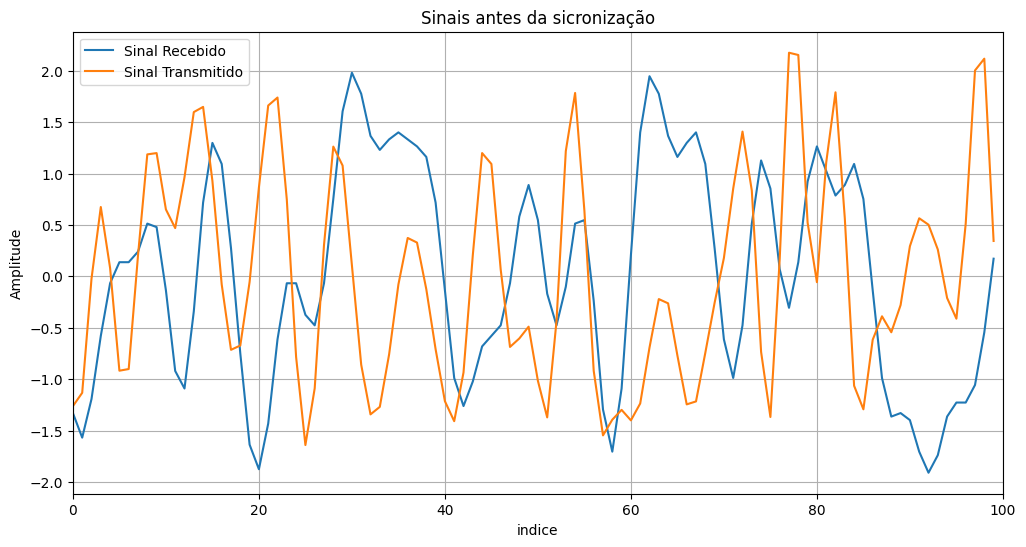

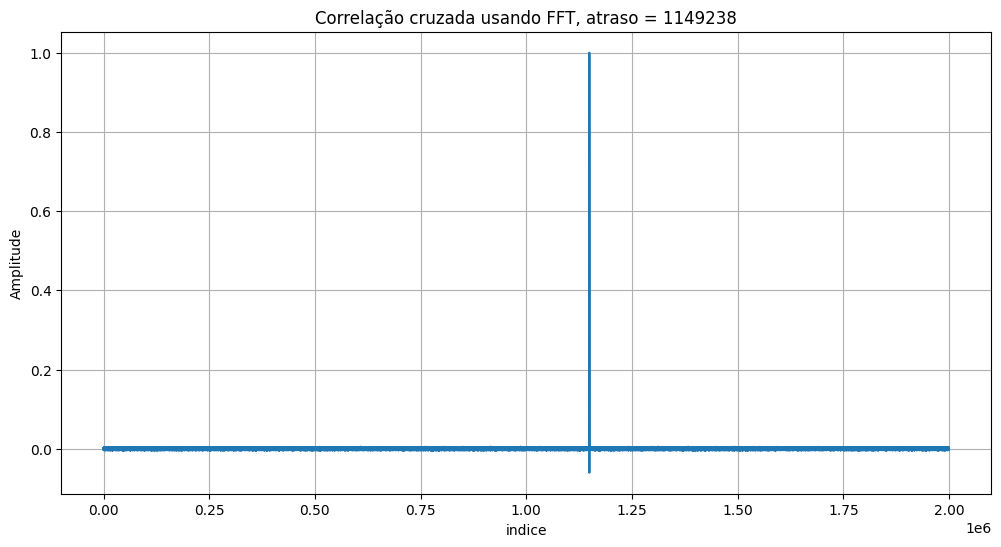

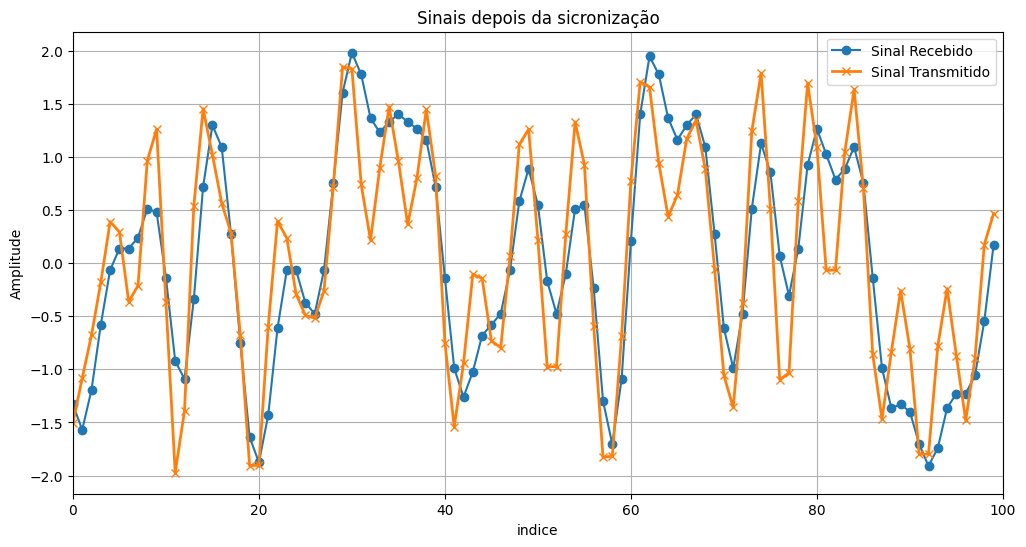

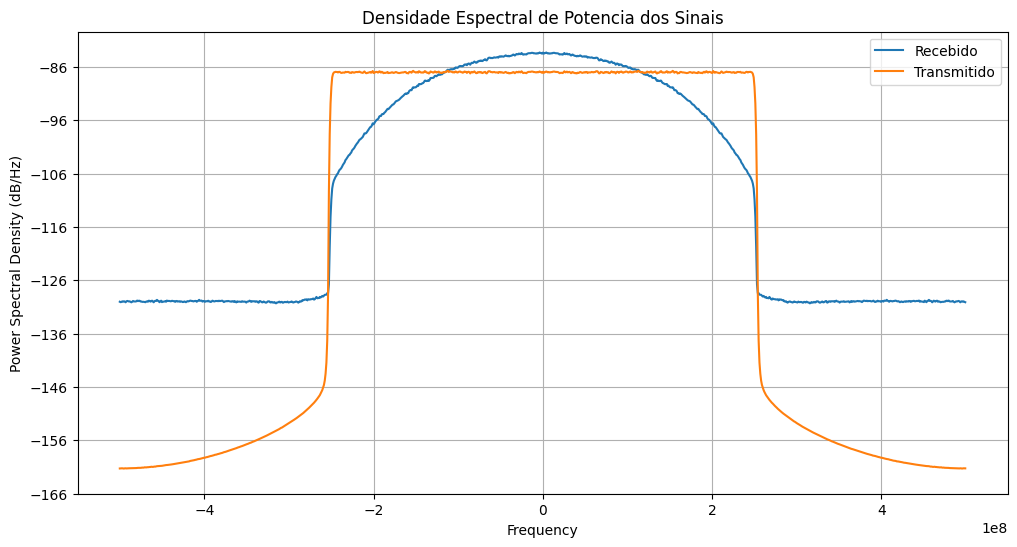

In [4]:
transmitido = pnorm(transmitido-np.mean(transmitido))

# paramCLKREC = parameters()
# paramCLKREC.isNyquist = True
# paramCLKREC.returnTiming = True
# paramCLKREC.ki = 1e-10
# paramCLKREC.kp = 1e-7
# #paramCLKREC.maxPPM = 1e-20

# recebidoclock, ted_values = gardnerClockRecovery(recebido, paramCLKREC)
# recebidoclock = recebidoclock[:,0]
#recebidoclock = np.append(recebidoclock,np.zeros(len(transmitido)-len(recebidoclock)))
recebidodecimado = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=fsScope,Fs_out=Dac['fs']*Modulador['SPS'],jitter_rms=0)[:,0]
recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

# recebidodecimado = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=fsScope,Fs_out=Dac['fs']*Modulador['SPS'],jitter_rms=0)[:,0]
# recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

# recebidodecimado, ted_values = gardnerClockRecovery(recebidodecimado, paramCLKREC)
# recebidodecimado = recebidodecimado[:,0]
# recebidodecimado = np.append(recebidodecimado,np.zeros(len(transmitido)-len(recebidodecimado)))


plt.figure()
plt.plot(recebidodecimado[0:100],label='Sinal Recebido')
plt.plot(transmitido[0:100],label='Sinal Transmitido')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais antes da sicronização')


transmitido = sicronizarSinais(transmitido,(recebidodecimado),plot=True)
transmitido = pnorm(transmitido-np.mean(transmitido))

recebidosicronizado = recebidodecimado

plt.figure()
plt.plot(recebidosicronizado[0:100],'-o',label='Sinal Recebido')
plt.plot(transmitido[0:100],'-x',linewidth='2',label='Sinal Transmitido')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais depois da sicronização')

plt.figure()
plt.title('Densidade Espectral de Potencia dos Sinais')
plt.psd(recebidosicronizado,Fs=1e9, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,Fs=1e9, NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.legend()

transmitido = transmitido[1000:-1000]
recebidosicronizado = recebidosicronizado[1000:-1000]

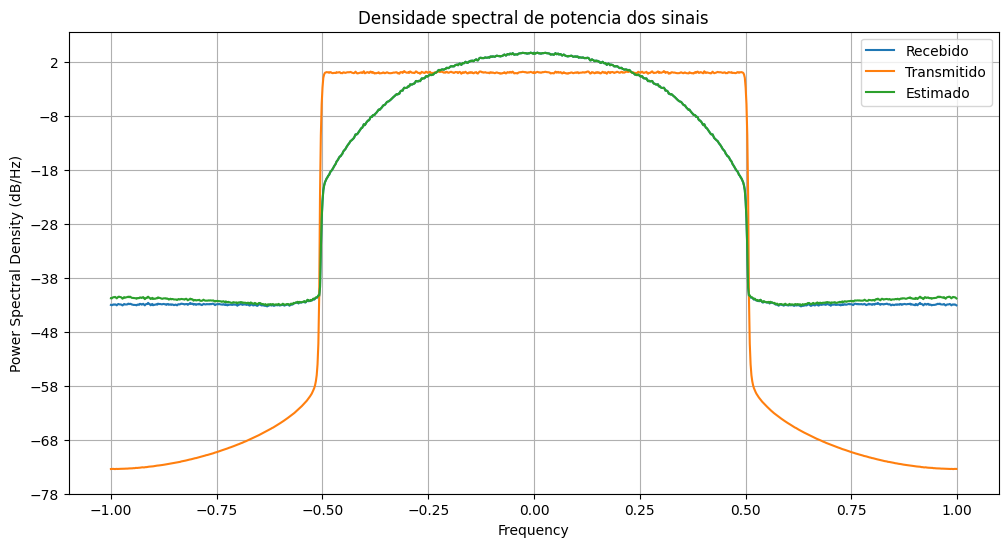

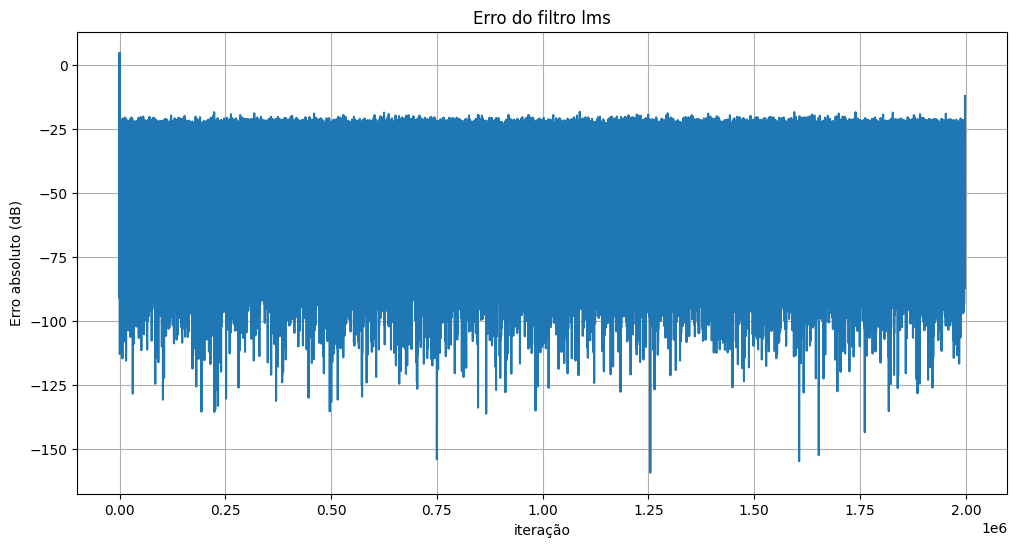

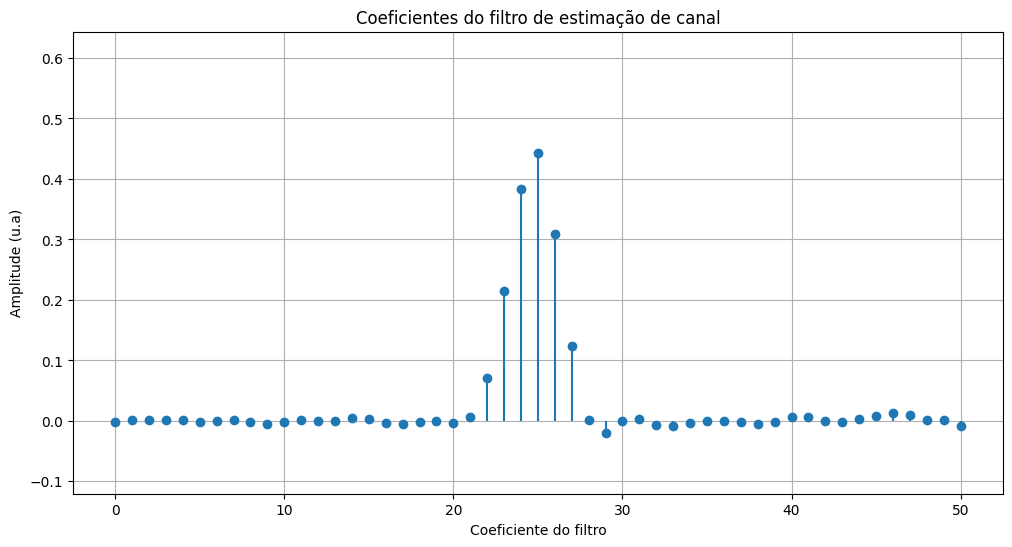

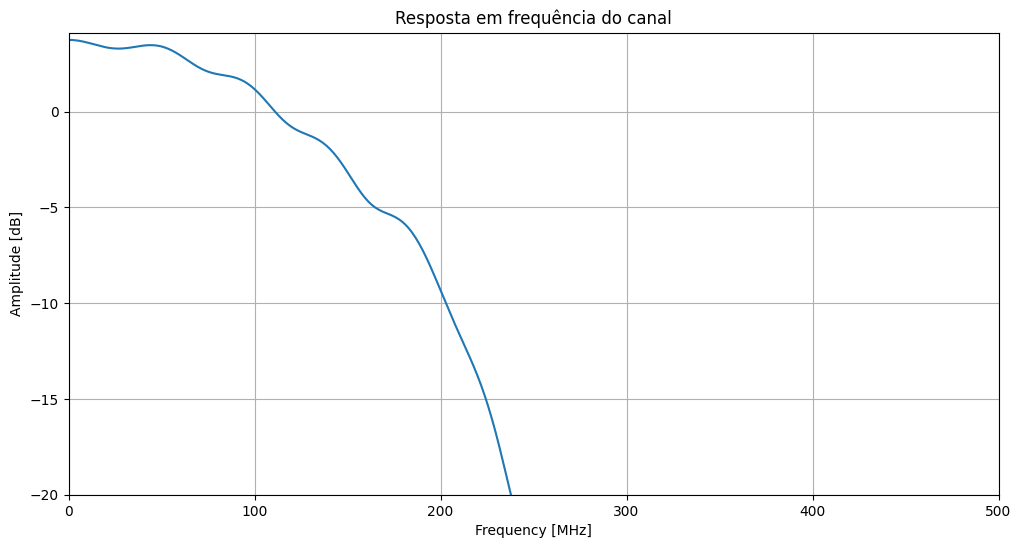

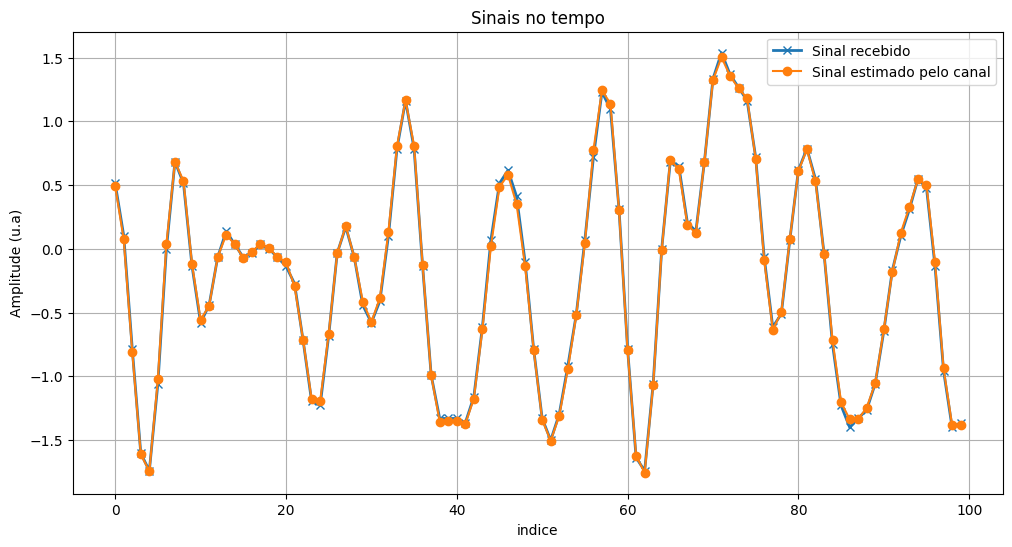

In [5]:
#Estimação do canal

#filtro lms
L = 51
μ = 0.02
out, h ,erro = lms(transmitido, recebidosicronizado, L,μ)
out = pnorm(out-np.mean(out))

plt.figure()
plt.psd(recebidosicronizado, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.psd(out, sides='twosided',NFFT = 1024, label = 'Estimado')
plt.legend()
plt.title('Densidade spectral de potencia dos sinais')

plt.figure()
plt.plot(10*np.log10(erro))
plt.xlabel('iteração')
plt.ylabel('Erro absoluto (dB)')
plt.title('Erro do filtro lms')
plt.grid()

plt.figure()
plt.stem(np.arange(len(h)), h, basefmt=" ")
plt.grid()
plt.ylim(min(h)-0.1,max(h)+0.2)
plt.xlabel('Coeficiente do filtro')
plt.ylabel('Amplitude (u.a)')
plt.title('Coeficientes do filtro de estimação de canal')

plt.figure()
fs = Dac['fs']*Modulador['SPS']
ω, h = sp.signal.freqz(b=h, a=1)
x = ω * fs * 1.0 / (2 * np.pi)
y = 20*np.log10(np.abs(h))

plt.plot(x/1e6, y)
plt.title('Resposta em frequência do canal')
plt.grid()
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.xlim(0,1*Dac['fs']/1e6)
plt.ylim(-20,1.1*np.max(y))

plt.figure()
plt.plot(recebidosicronizado[500:600],'-x',linewidth='2',label='Sinal recebido')
plt.plot(out[500:600],'-o',label='Sinal estimado pelo canal')
plt.xlabel('indice')
plt.ylabel('Amplitude (u.a)')
plt.title('Sinais no tempo')
plt.grid()
plt.legend()

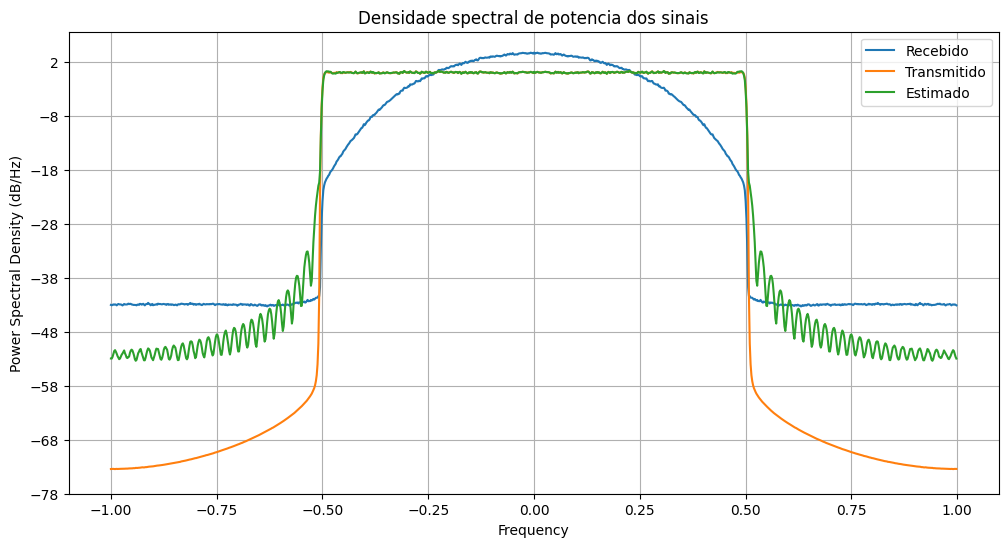

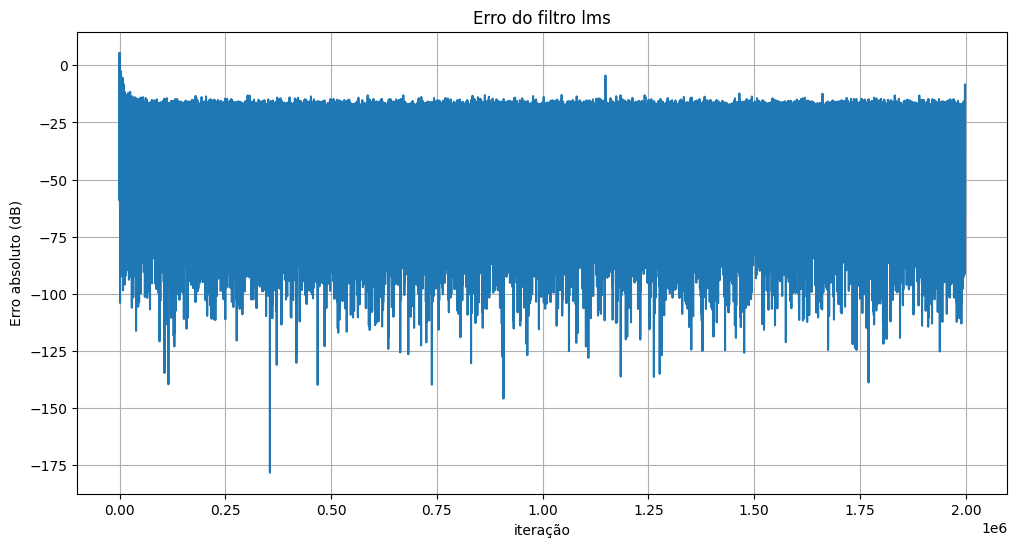

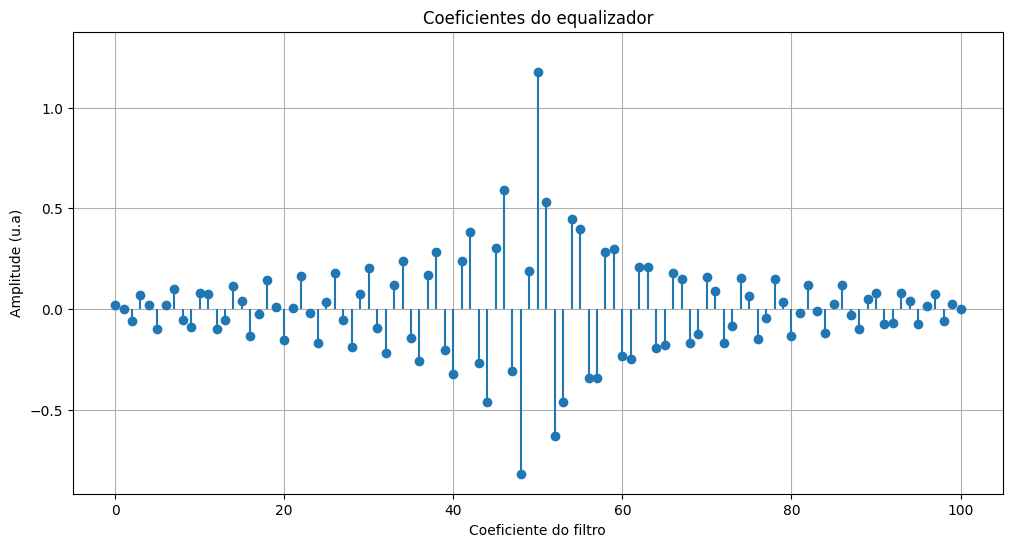

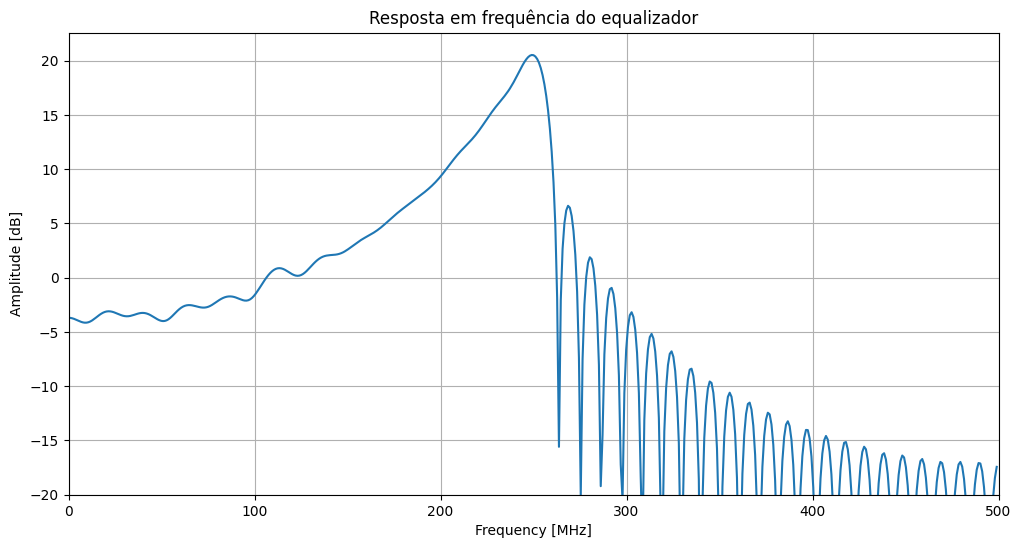

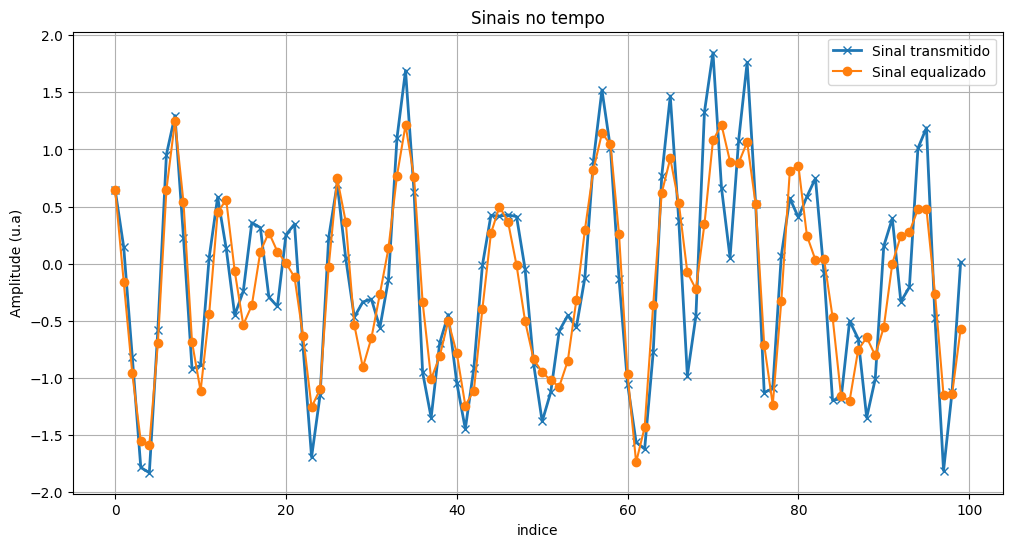

In [13]:
#Estimação do equalizador

#filtro lms
L = 101
μ = 0.01
out, heq ,erro = lms(recebidosicronizado, transmitido, L,μ)
out = pnorm(out-np.mean(out))



plt.figure()
plt.psd(recebidosicronizado, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.psd(out, sides='twosided',NFFT = 1024, label = 'Estimado')
plt.legend()
plt.title('Densidade spectral de potencia dos sinais')

plt.figure()
plt.plot(10*np.log10(erro))
plt.xlabel('iteração')
plt.ylabel('Erro absoluto (dB)')
plt.title('Erro do filtro lms')
plt.grid()

plt.figure()
plt.stem(np.arange(len(heq)), heq, basefmt=" ")
plt.grid()
plt.ylim(min(heq)-0.1,max(heq)+0.2)
plt.xlabel('Coeficiente do filtro')
plt.ylabel('Amplitude (u.a)')
plt.title('Coeficientes do equalizador')

plt.figure()
fs = Dac['fs']*Modulador['SPS']
ω, h = sp.signal.freqz(b=heq, a=1)
x = ω * fs * 1.0 / (2 * np.pi)
y = 20*np.log10(np.abs(h))

plt.plot(x/1e6, y)
plt.title('Resposta em frequência do equalizador')
plt.grid()
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.xlim(0,500)
plt.ylim(-20,1.1*np.max(y))

plt.figure()
plt.plot(transmitido[500:600],'-x',linewidth='2',label='Sinal transmitido')
plt.plot(out[500:600],'-o',label='Sinal equalizado')
plt.xlabel('indice')
plt.ylabel('Amplitude (u.a)')
plt.title('Sinais no tempo')
plt.grid()
plt.legend()



In [14]:
np.save('Taps-pre-equalizacao-500Mbs',heq)

# Realizando a pre-equalização

+0,"No error"

Numero de pontos do osciloscopio: 2000000
Frequencia de amostragem do osciloscopio: 1000.0 MHz
BER: 1e-06
SER: 2e-06
Numero de error totais: 2
SNR: 21.025431503341807 dB
Numero de erros teoricos para essa SNR: 8.268085059816558e-13


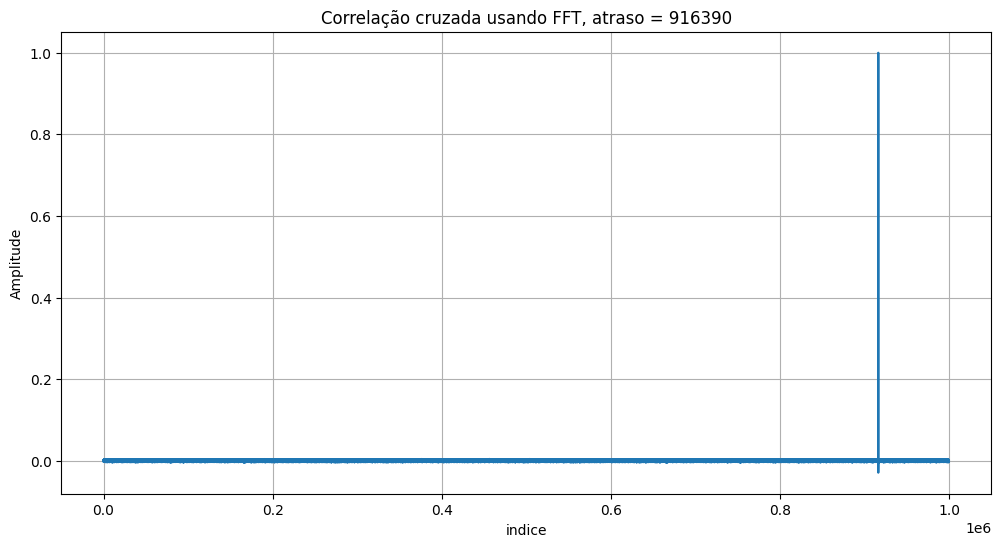

<Figure size 1200x600 with 0 Axes>

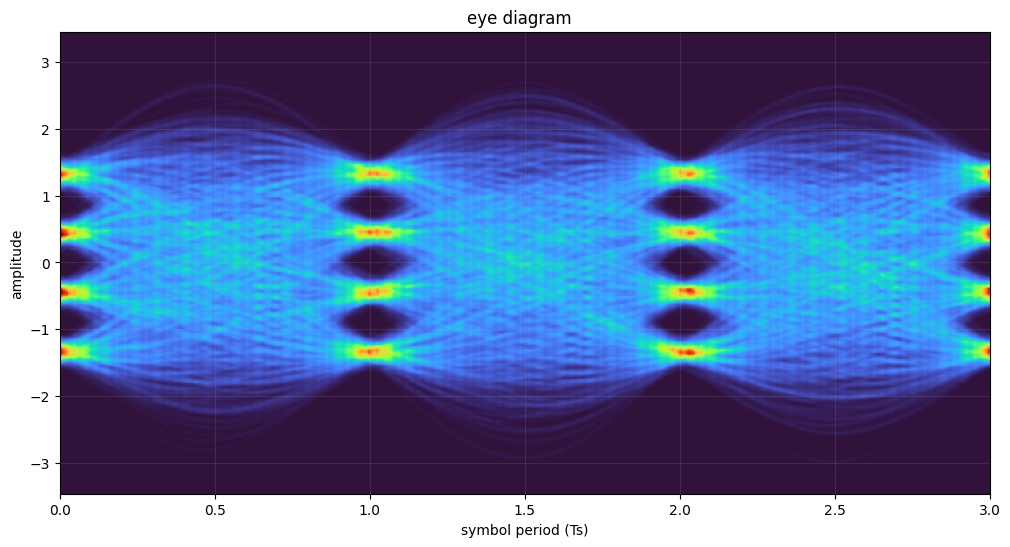

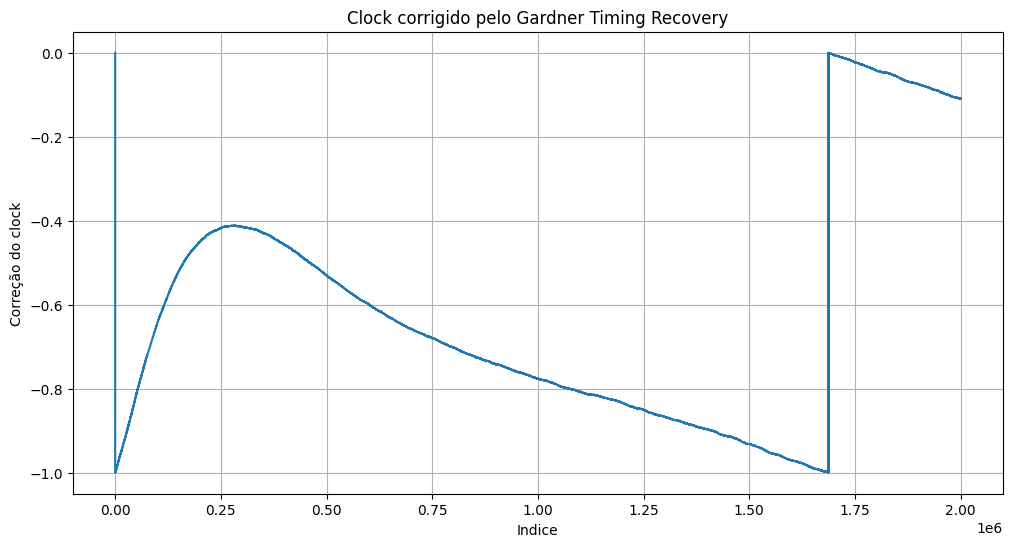

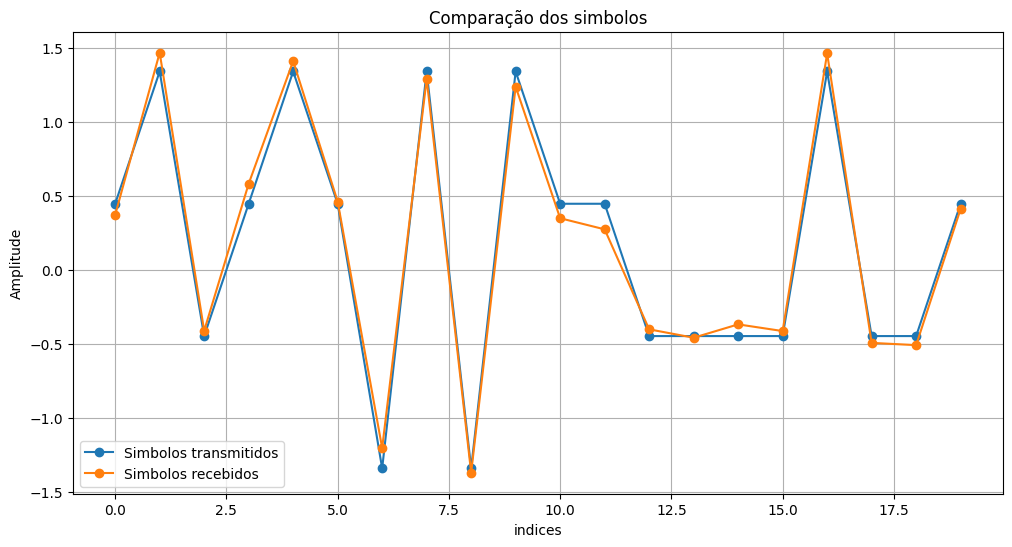

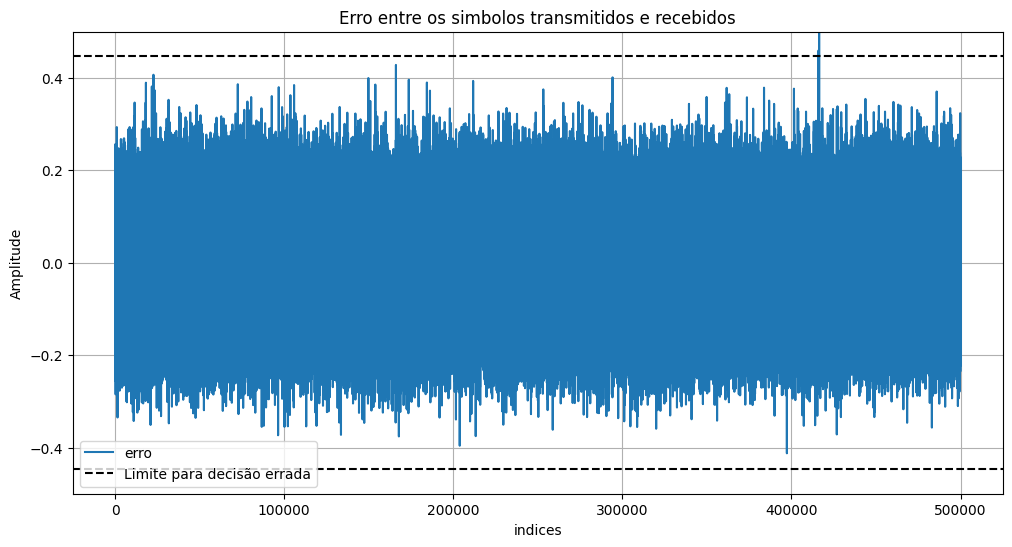

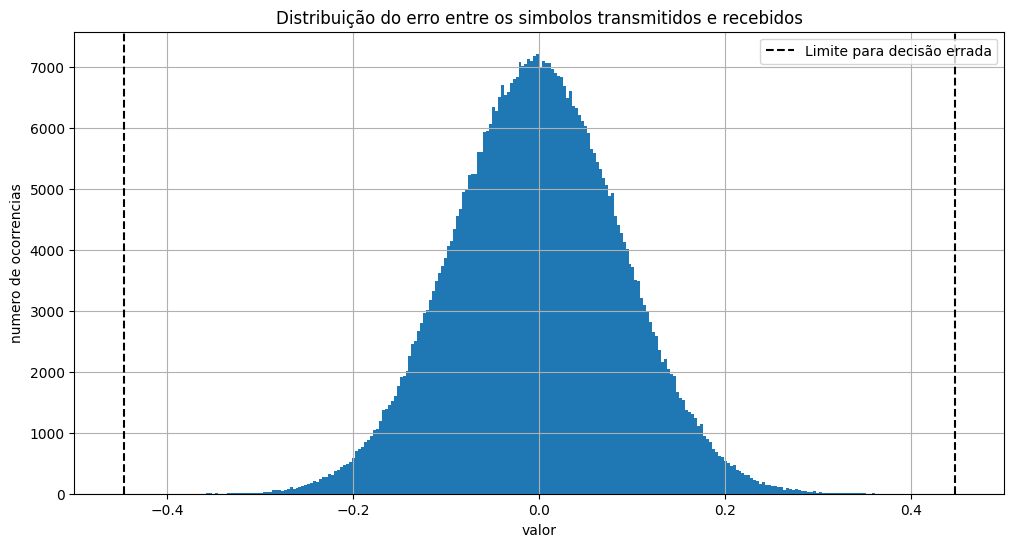

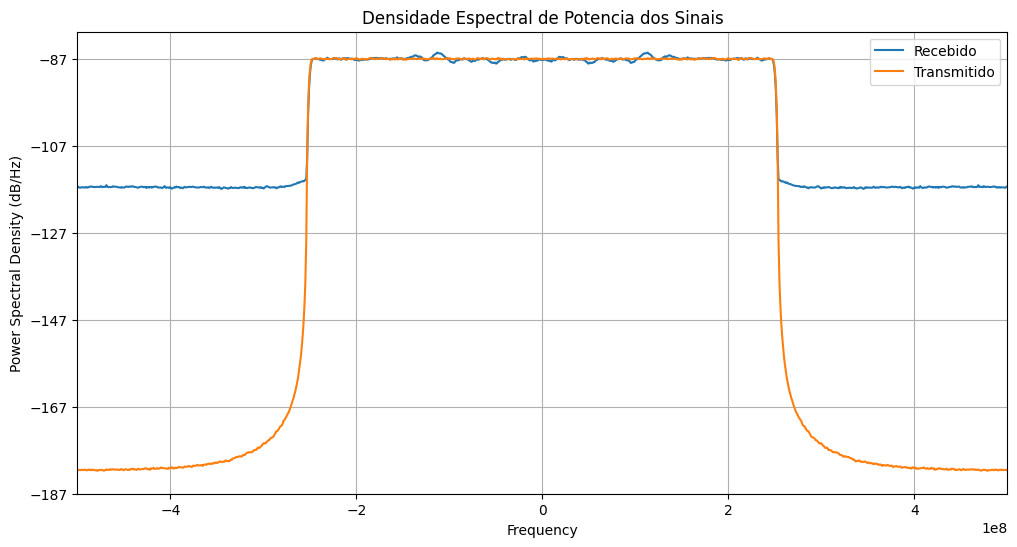

In [27]:
Modulador['W'] = np.load('Taps-pre-equalizacao-500Mbs.npy')
Modulador['nsimbolos'] =1e6
# Modulador = {
#     'M': 4,
#     'nsimbolos': 3e5,
#     'SPS': 4,
#     'formatoPulso': 'rrc', #'rect','nrz','rrc'
#     'nTaps': 1024,
#     'alpha': 0.01,
#     'W': np.array([])
# }

# Dac = {
#     'dispositivo': DAC,
#     'Porta': 2,
#     'fs': 500e6,
#     'V_High': 4,
#     'V_Low': 0,
#     'filtro': 'NORMal'
# }

Osciloscopio = {
    'dispositivo': scope,
    'canais': np.array([3]),
    'tempo': 1*Modulador['nsimbolos']/(Dac['fs']),
    'vDivisao': np.array([0.4]),
    'impedancia': np.array(['FIFTy']),
    'triggerChannel': np.array([0]),
    'triggerAmp': np.array([0]),
    'offset': np.array([2]),
}

ClockRecovery = {
    'Ki': 1e-10,
    'Kp': 1e-5,
}

#Gerando os sinais transmitidos
bits,pulso,transmitido, transmitidoequalizados = Gerar_Simbolos(Modulador)
#Gerando uma onda arbitraria no DAC
#Onda_Dac_Keysight(Dac,Modulador,transmitido,'teste')
Onda_Dac_Keysight(Dac,Modulador,transmitidoequalizados,'teste')
DAC.query('*OPC?')   
#Configurando o osciloscopio
ConfigurarScope(Osciloscopio)
# Fixar o sinal no osciloscopio
Osciloscopio['dispositivo'].write('digitize')
Osciloscopio['dispositivo'].query('*OPC?')   

t,recebido = AdquirirOnda(Osciloscopio['dispositivo'],3)
fsScope = float(Osciloscopio['dispositivo'].query(':ACQuire:SRATe?'))

print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')


ber,ser,Nerros,SNRdB = recepcao(transmitido,recebido,fsScope,Modulador,Dac,ClockRecovery,plot=True)

In [24]:
def recepcao(transmitido,recebido,fsScope,Modulador,Dac,ClockRecovery,plot=False):
    paramCLKREC = parameters()
    paramCLKREC.isNyquist = True
    paramCLKREC.returnTiming = True
    paramCLKREC.ki = ClockRecovery['Ki']
    paramCLKREC.kp = ClockRecovery['Kp']
    #paramCLKREC.maxPPM = 1

    transmitido = pnorm(transmitido-np.mean(transmitido))
    recebido = pnorm(recebido-np.mean(recebido))

    pulso = pulseShape(Modulador['formatoPulso'], (fsScope/Dac['fs']), Modulador['nTaps'], Modulador['alpha'])
    pulso = pulso/max(abs(pulso))
    filtrocasado = firFilter(pulso,recebido)
    filtrocasado = pnorm(filtrocasado-np.mean(filtrocasado))
    filtrocasado, ted_values = gardnerClockRecovery(filtrocasado, paramCLKREC)
    filtrocasado = pnorm(filtrocasado-np.mean(filtrocasado))
    filtrocasado = filtrocasado[:,0]

    recebidodecimado = clockSamplingInterp(filtrocasado.reshape(-1,1),Fs_in=(fsScope/Dac['fs']),Fs_out=1,jitter_rms=0)[:,0]
    recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))
    recebidosicronizado = recebidodecimado

    simbolos = modulateGray(bits,4,'pam')
    simbolos = pnorm(simbolos-np.mean(simbolos))

    simbolos,delay = sicronizarSinais(simbolos,(recebidosicronizado),plot=plot,returnTiming=True)
    #simbolos = simbolos[0:len(simbolos)]
    simbolos = pnorm(simbolos-np.mean(simbolos))

    simbolos = simbolos[500000:]
    recebidosicronizado = recebidosicronizado[500000:]


    diferenca = simbolos - recebidosicronizado
    ber,ser,SNRdB = (fastBERcalc(pnorm(recebidosicronizado), pnorm(simbolos), 4, 'pam'))
    erros = np.argwhere(np.abs(diferenca)>0.4470)

    print(f'BER: {ber[0]}')
    print(f'SER: {ser[0]}')
    print(f'Numero de error totais: {len(erros)}')
    print(f'SNR: {SNRdB[0]} dB')

    from scipy.special import erfc

    def Q(x):
        return 0.5*erfc(x/np.sqrt(2))
    SNR = 10**(SNRdB[0]/10)
    print(f'Numero de erros teoricos para essa SNR: {2*(4-1)/4*Q(np.sqrt((6*SNR)/(4**2-1)))}')

    # print(len(recebidosicronizado))
    # print(len(simbolos))
    # # recebidosicronizado = recebidosicronizado[1:-1]
    # # simbolos = simbolos[1:-1]

    if plot==True:
        plt.figure()
        eyediagram(filtrocasado[1000000:],len(filtrocasado[1000000:]),(fsScope/Dac['fs']),ptype='fancy')
        plt.figure()
        plt.plot(ted_values)
        plt.xlabel('Indice')
        plt.ylabel('Correção do clock')
        plt.title('Clock corrigido pelo Gardner Timing Recovery')
        plt.grid()
        plt.figure()
        plt.plot((simbolos)[0:0+20],'o-',label='Simbolos transmitidos')
        plt.plot((recebidosicronizado)[0:0+20],'o-',label='Simbolos recebidos')
        plt.title('Comparação dos simbolos')
        plt.xlabel('indices')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.legend()

        plt.figure()
        plt.plot(diferenca,label='erro')
        plt.axhline(-0.4470,linestyle='--',color='k',label='Limite para decisão errada')
        plt.axhline(0.4470,linestyle='--',color='k')
        plt.title('Erro entre os simbolos transmitidos e recebidos')
        plt.xlabel('indices')
        plt.ylabel('Amplitude')
        plt.ylim(-0.5,0.5)
        plt.grid()
        plt.legend()

        plt.figure()
        plt.hist(diferenca,bins=500)
        plt.axvline(-0.4470,linestyle='--',color='k',label='Limite para decisão errada')
        plt.axvline(0.4470,linestyle='--',color='k')
        plt.title('Distribuição do erro entre os simbolos transmitidos e recebidos')
        plt.xlim(-0.5,0.5)
        plt.xlabel('valor')
        plt.ylabel('numero de ocorrencias')
        plt.grid()
        plt.legend()

        plt.figure()
        plt.title('Densidade Espectral de Potencia dos Sinais')
        plt.psd(recebido,Fs=fsScope, NFFT = 1024, sides='twosided', label = 'Recebido')
        plt.psd(transmitido,Fs=Dac['fs']*Modulador['SPS'], NFFT = 1024, sides='twosided', label = 'Transmitido')
        plt.xlim(-0.5e9,0.5e9)
        plt.legend()

        # plt.figure()
        # plt.plot(erros,'o-')
        # plt.title(f'Indice dos erros: atraso da sicronização = {delay}')
        # plt.grid()
        # plt.xlabel('Indice do erro')
        # plt.ylabel('Posição do erro')
        # plt.xlim(0,len(erros)-1)
    return ber[0],ser[0],len(erros),SNRdB[0]

Numero de pontos do osciloscopio: 2000000
Frequencia de amostragem do osciloscopio: 1000.0 MHz
500000
500000
BER: 1e-06
SER: 2e-06
Numero de error totais: 3
SNR: 20.678216308734818 dB
Numero de erros teoricos para essa SNR: [6.01523191e-12]


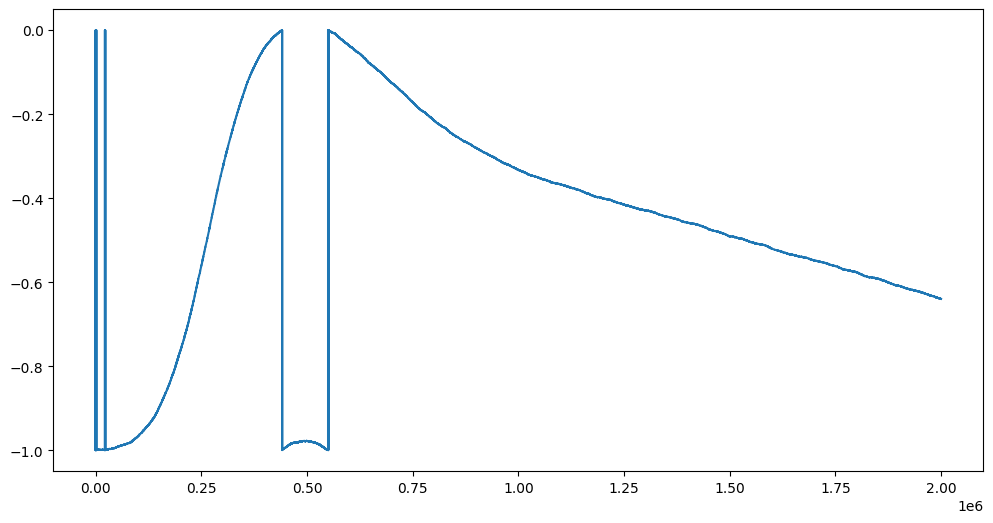

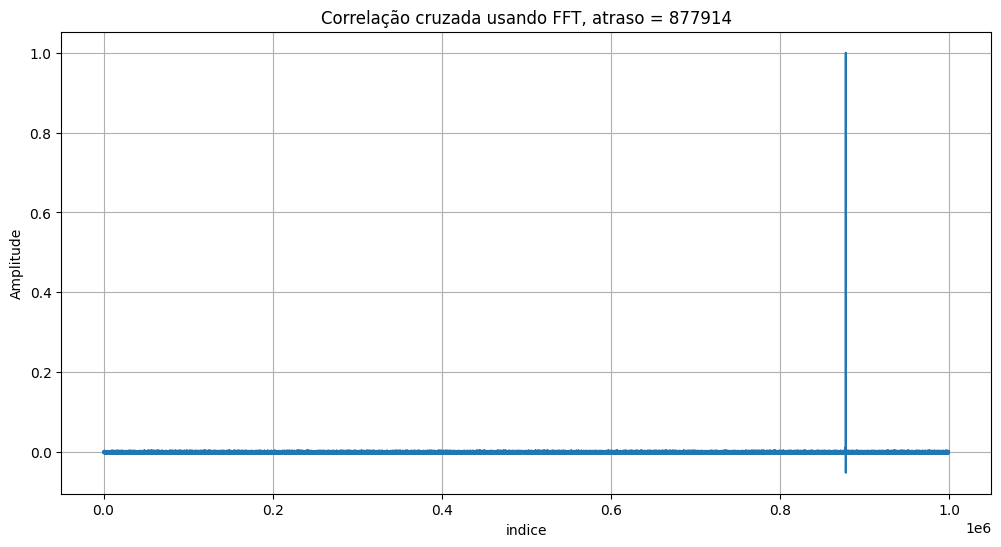

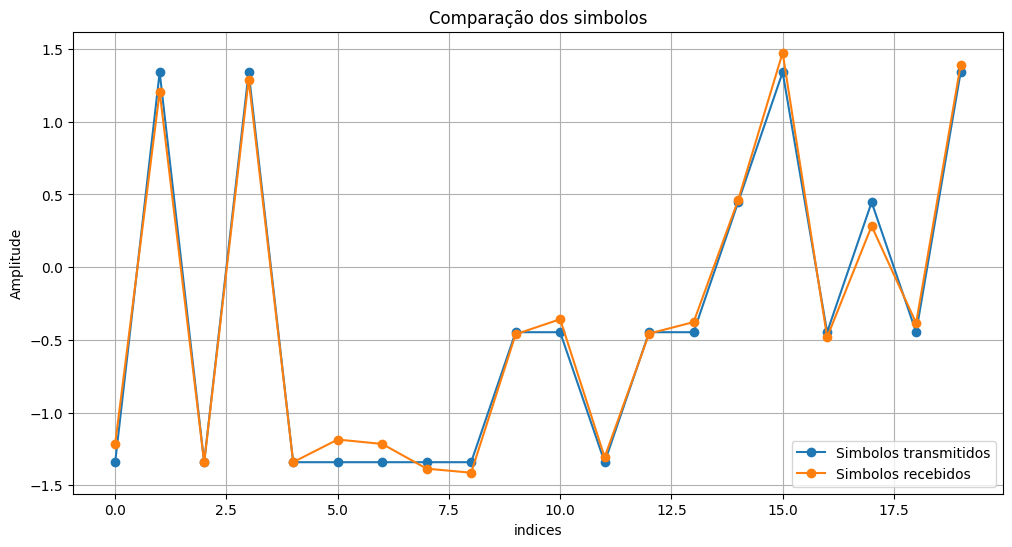

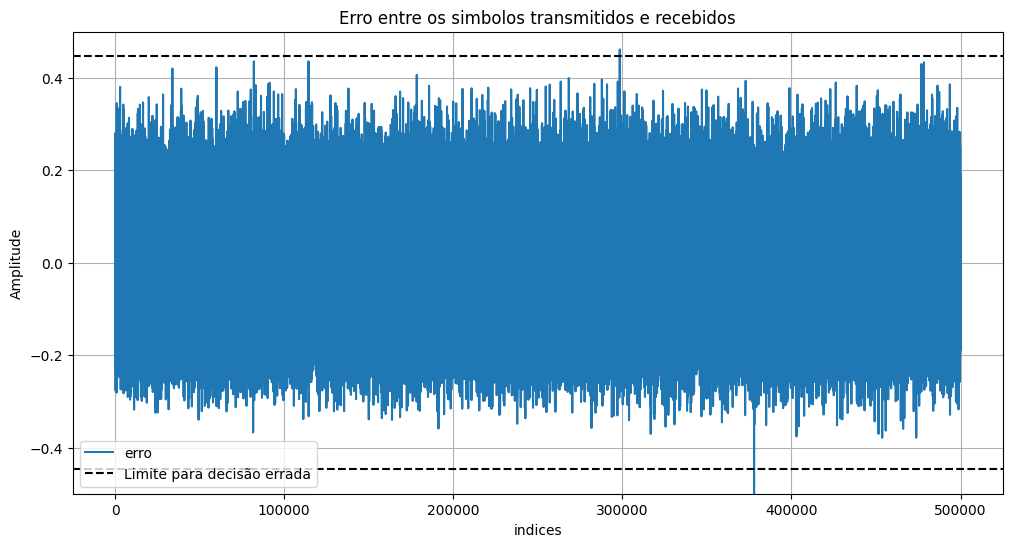

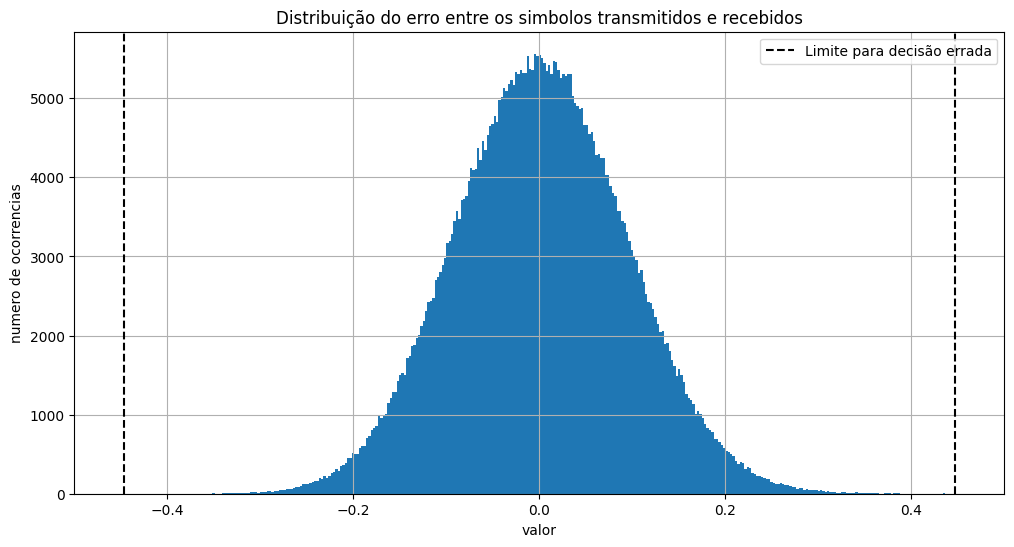

<Figure size 1200x600 with 0 Axes>

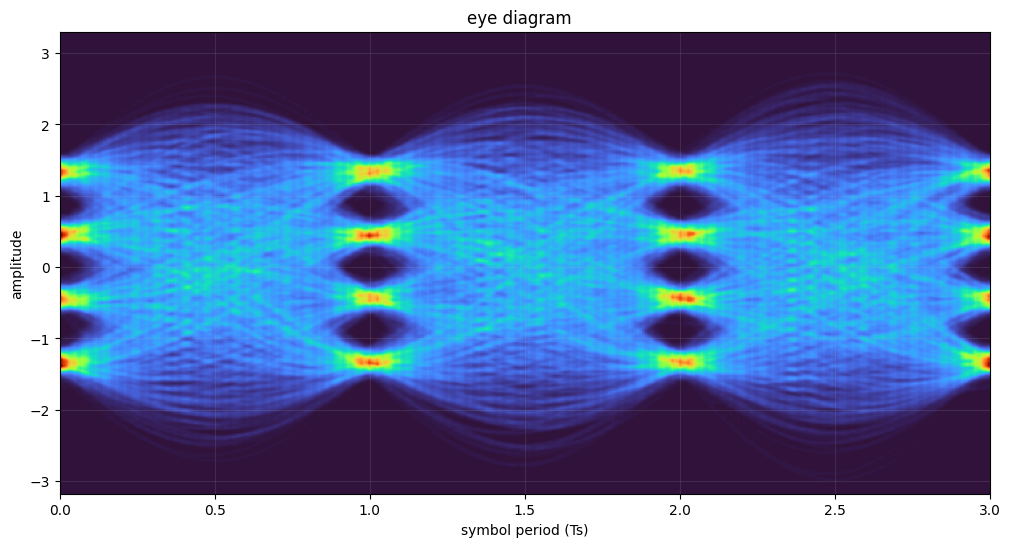

(0.0, 2.0)

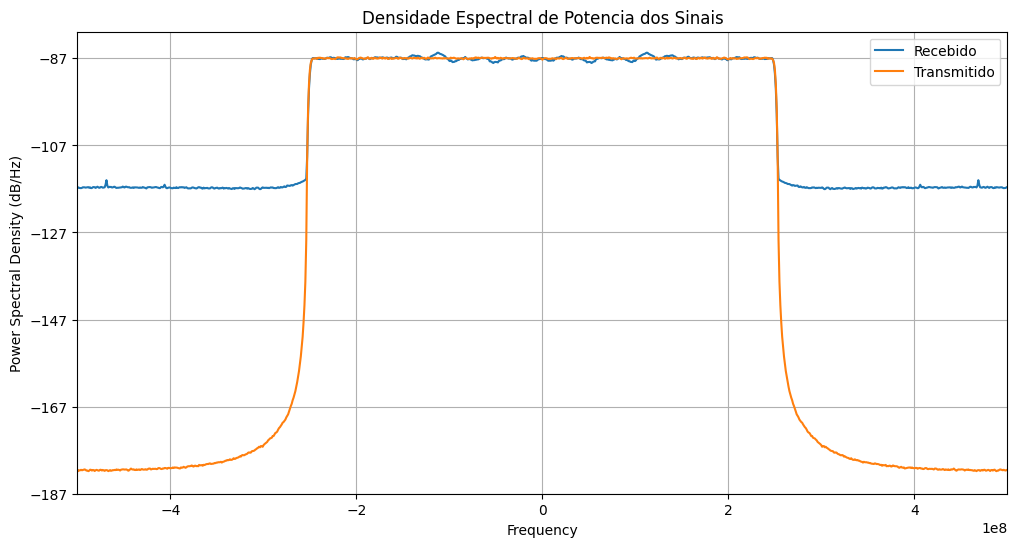

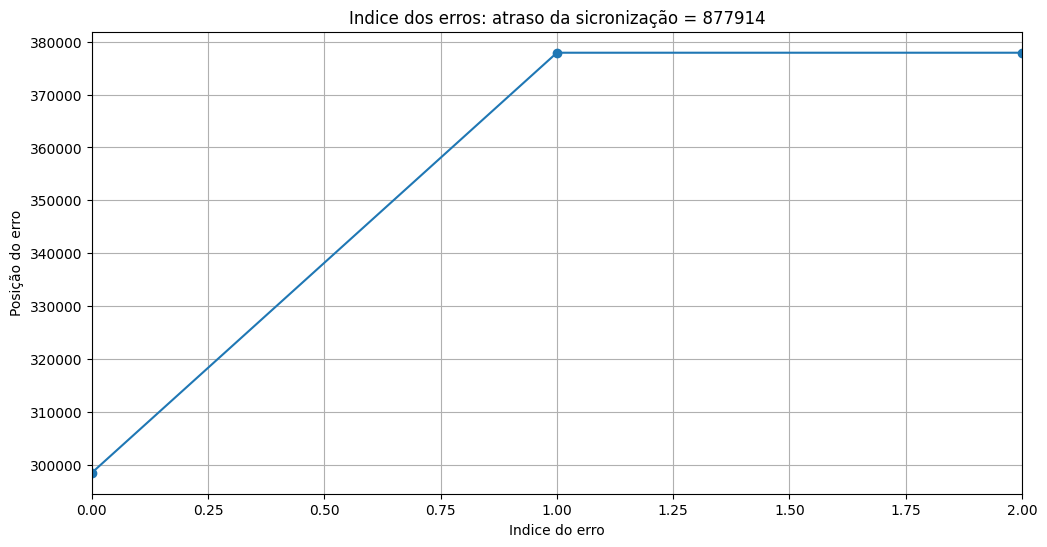

In [37]:
paramCLKREC = parameters()
paramCLKREC.isNyquist = True
paramCLKREC.returnTiming = True
paramCLKREC.ki = 1e-10
paramCLKREC.kp = 1e-5
#paramCLKREC.maxPPM = 1


print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')

transmitido = pnorm(transmitido-np.mean(transmitido))
recebido = pnorm(recebido-np.mean(recebido))

pulso = pulseShape(Modulador['formatoPulso'], (fsScope/Dac['fs']), Modulador['nTaps'], Modulador['alpha'])
pulso = pulso/max(abs(pulso))
filtrocasado = firFilter(pulso,recebido)
filtrocasado = pnorm(filtrocasado-np.mean(filtrocasado))
filtrocasado, ted_values = gardnerClockRecovery(filtrocasado, paramCLKREC)
filtrocasado = pnorm(filtrocasado-np.mean(filtrocasado))
plt.plot(ted_values)
filtrocasado = filtrocasado[:,0]

# paramDec = parameters()
# paramDec.SpS_in  = int(fsScope/Dac['fs'])
# paramDec.SpS_out = 1
# recebidodecimado = decimate(filtrocasado, paramDec)[:,0]
# recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))
recebidodecimado = clockSamplingInterp(filtrocasado.reshape(-1,1),Fs_in=(fsScope/Dac['fs']),Fs_out=1,jitter_rms=0)[:,0]
recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))
recebidosicronizado = recebidodecimado

simbolos = modulateGray(bits,4,'pam')
simbolos = pnorm(simbolos-np.mean(simbolos))

simbolos,delay = sicronizarSinais(simbolos,(recebidosicronizado),plot=True,returnTiming=True)
#simbolos = simbolos[0:len(simbolos)]
simbolos = pnorm(simbolos-np.mean(simbolos))

simbolos = simbolos[500000:]
recebidosicronizado = recebidosicronizado[500000:]

print(len(recebidosicronizado))
print(len(simbolos))
# recebidosicronizado = recebidosicronizado[1:-1]
# simbolos = simbolos[1:-1]

plt.figure()
plt.plot((simbolos)[0:0+20],'o-',label='Simbolos transmitidos')
plt.plot((recebidosicronizado)[0:0+20],'o-',label='Simbolos recebidos')
plt.title('Comparação dos simbolos')
plt.xlabel('indices')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.figure()
diferenca = simbolos - recebidosicronizado
plt.plot(diferenca,label='erro')
plt.axhline(-0.4470,linestyle='--',color='k',label='Limite para decisão errada')
plt.axhline(0.4470,linestyle='--',color='k')
plt.title('Erro entre os simbolos transmitidos e recebidos')
plt.xlabel('indices')
plt.ylabel('Amplitude')
plt.ylim(-0.5,0.5)
plt.grid()
plt.legend()

plt.figure()
plt.hist(diferenca,bins=500)
plt.axvline(-0.4470,linestyle='--',color='k',label='Limite para decisão errada')
plt.axvline(0.4470,linestyle='--',color='k')
plt.title('Distribuição do erro entre os simbolos transmitidos e recebidos')
plt.xlim(-0.5,0.5)
plt.xlabel('valor')
plt.ylabel('numero de ocorrencias')
plt.grid()
plt.legend()

ber,ser,SNRdB = (fastBERcalc(pnorm(recebidosicronizado), pnorm(simbolos), 4, 'pam'))
erros = np.argwhere(np.abs(diferenca)>0.4470)
print(f'BER: {ber[0]}')
print(f'SER: {ser[0]}')
print(f'Numero de error totais: {len(erros)}')
print(f'SNR: {SNRdB[0]} dB')

from scipy.special import erfc

def Q(x):
    return 0.5*erfc(x/np.sqrt(2))
SNR = 10**(SNRdB/10)
print(f'Numero de erros teoricos para essa SNR: {2*(4-1)/4*Q(np.sqrt((6*SNR)/(4**2-1)))}')

plt.figure()
eyediagram(filtrocasado[1000000:],len(filtrocasado[1000000:]),(fsScope/Dac['fs']),ptype='fancy')

plt.figure()
plt.title('Densidade Espectral de Potencia dos Sinais')
plt.psd(recebido,Fs=fsScope, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,Fs=Dac['fs']*Modulador['SPS'], NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.xlim(-0.5e9,0.5e9)
plt.legend()

plt.figure()
plt.plot(erros,'o-')
plt.title(f'Indice dos erros: atraso da sicronização = {delay}')
plt.grid()
plt.xlabel('Indice do erro')
plt.ylabel('Posição do erro')
plt.xlim(0,len(erros)-1)

Numero de pontos do osciloscopio: 2000000
Frequencia de amostragem do osciloscopio: 1000.0 MHz
500000
500000
BER: 0.156116
SER: 0.309552
Numero de error totais: 179919
SNR: 6.474083176241285 dB
Numero de erros teoricos para essa SNR: [0.13697138]


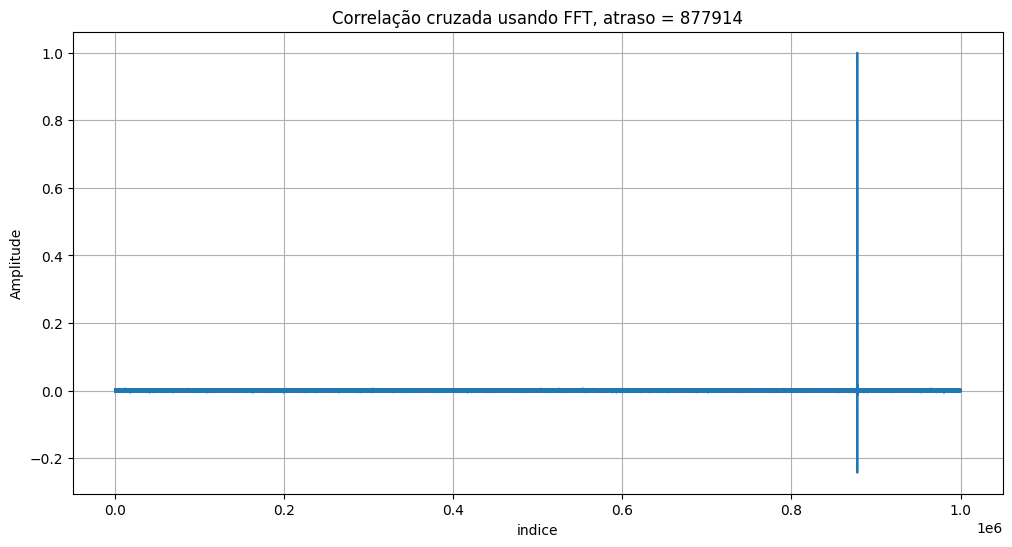

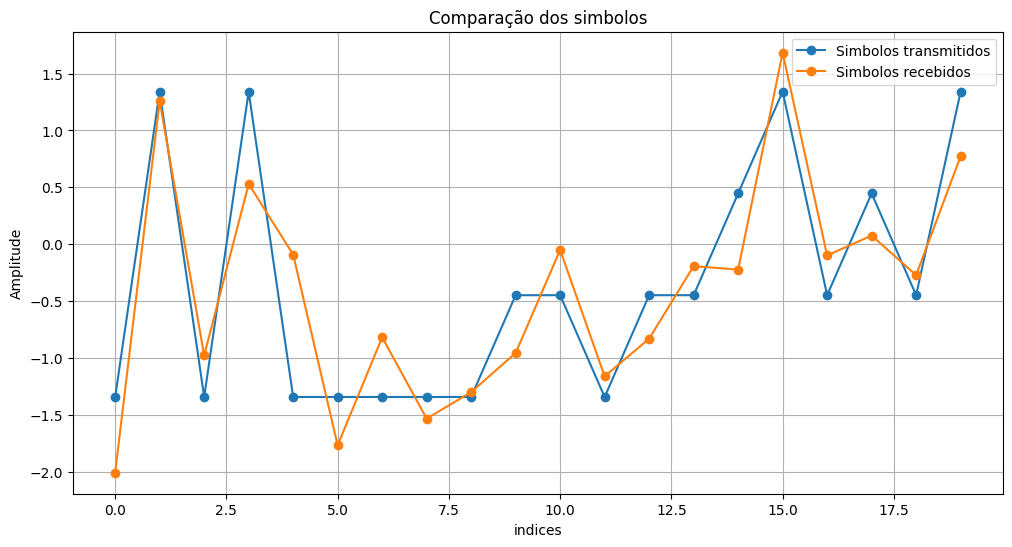

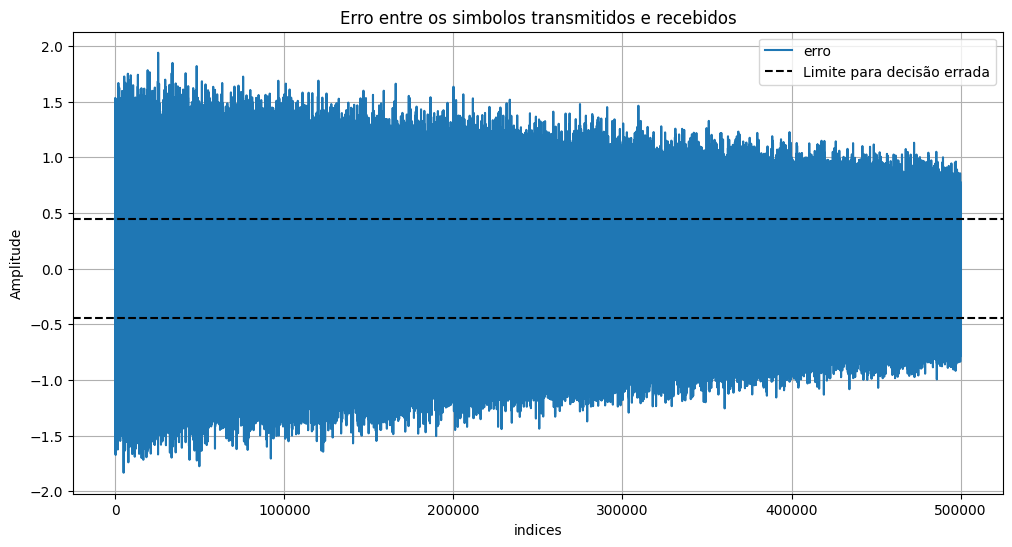

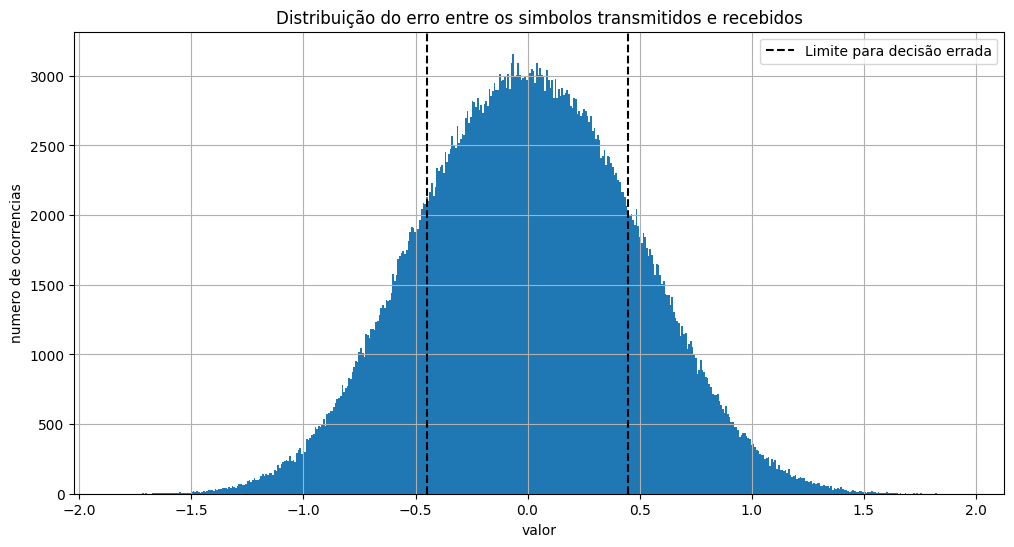

<Figure size 1200x600 with 0 Axes>

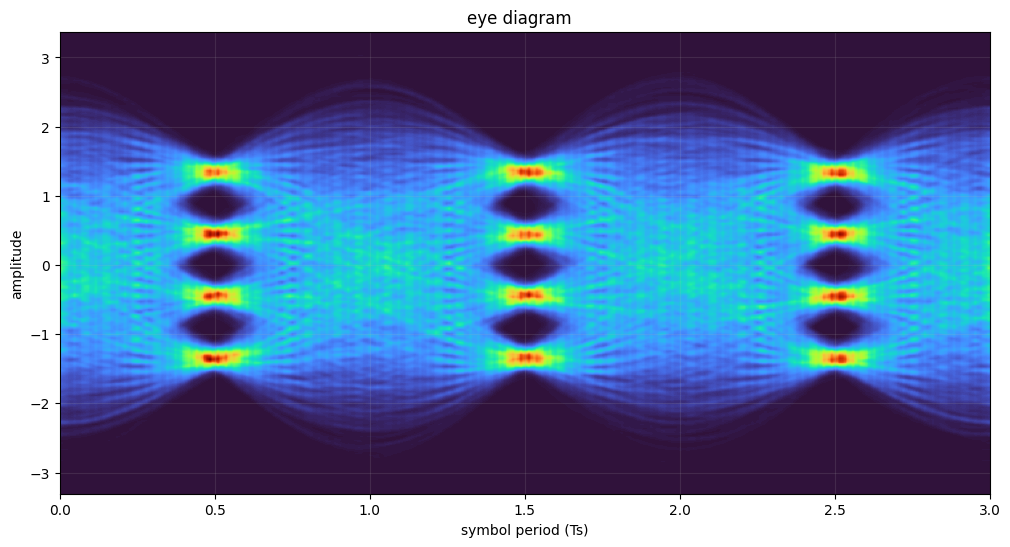

(0.0, 179918.0)

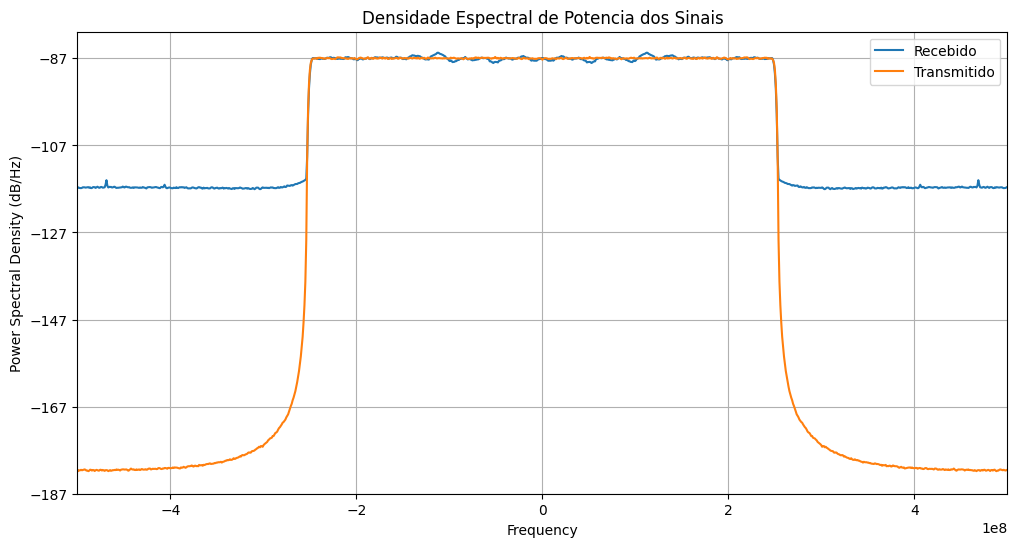

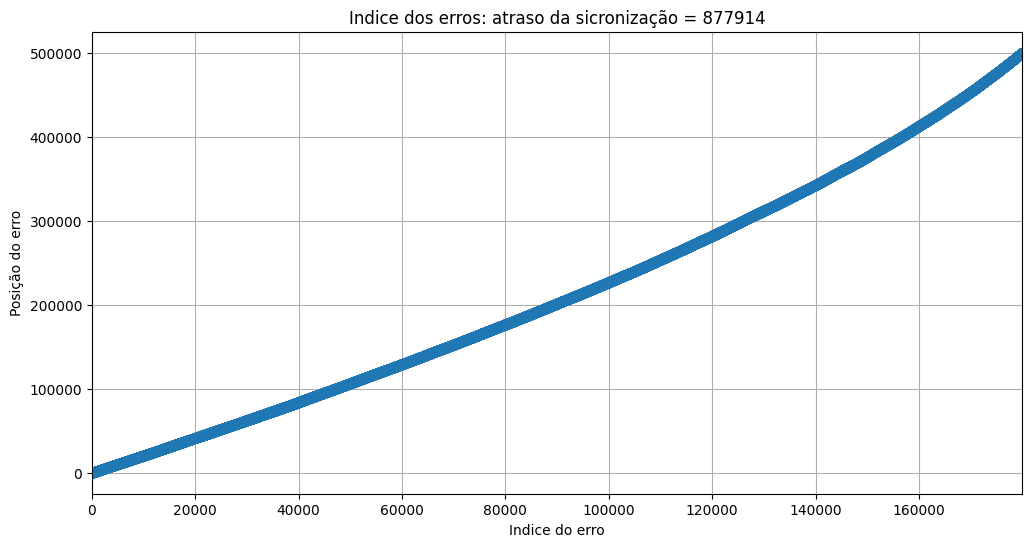

In [40]:
paramCLKREC = parameters()
paramCLKREC.isNyquist = True
paramCLKREC.returnTiming = True
paramCLKREC.ki = 1e-10
paramCLKREC.kp = 1e-5
#paramCLKREC.maxPPM = 1


print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')

transmitido = pnorm(transmitido-np.mean(transmitido))
recebido = pnorm(recebido-np.mean(recebido))

pulso = pulseShape(Modulador['formatoPulso'], (fsScope/Dac['fs']), Modulador['nTaps'], Modulador['alpha'])
pulso = pulso/max(abs(pulso))
filtrocasado = firFilter(pulso,recebido)
filtrocasado = pnorm(filtrocasado-np.mean(filtrocasado))
# filtrocasado, ted_values = gardnerClockRecovery(filtrocasado, paramCLKREC)
# filtrocasado = pnorm(filtrocasado-np.mean(filtrocasado))
# plt.plot(ted_values)
# filtrocasado = filtrocasado[:,0]

# paramDec = parameters()
# paramDec.SpS_in  = int(fsScope/Dac['fs'])
# paramDec.SpS_out = 1
# recebidodecimado = decimate(filtrocasado, paramDec)[:,0]
# recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))
recebidodecimado = clockSamplingInterp(filtrocasado.reshape(-1,1),Fs_in=(fsScope/Dac['fs']),Fs_out=1,jitter_rms=0)[:,0]
recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))
recebidosicronizado = recebidodecimado

simbolos = modulateGray(bits,4,'pam')
simbolos = pnorm(simbolos-np.mean(simbolos))

simbolos,delay = sicronizarSinais(simbolos,(recebidosicronizado),plot=True,returnTiming=True)
#simbolos = simbolos[0:len(simbolos)]
simbolos = pnorm(simbolos-np.mean(simbolos))

simbolos = simbolos[500000:]
recebidosicronizado = recebidosicronizado[500000:]

print(len(recebidosicronizado))
print(len(simbolos))
# recebidosicronizado = recebidosicronizado[1:-1]
# simbolos = simbolos[1:-1]

plt.figure()
plt.plot((simbolos)[0:0+20],'o-',label='Simbolos transmitidos')
plt.plot((recebidosicronizado)[0:0+20],'o-',label='Simbolos recebidos')
plt.title('Comparação dos simbolos')
plt.xlabel('indices')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.figure()
diferenca = simbolos - recebidosicronizado
plt.plot(diferenca,label='erro')
plt.axhline(-0.4470,linestyle='--',color='k',label='Limite para decisão errada')
plt.axhline(0.4470,linestyle='--',color='k')
plt.title('Erro entre os simbolos transmitidos e recebidos')
plt.xlabel('indices')
plt.ylabel('Amplitude')
#plt.ylim(-0.5,0.5)
plt.grid()
plt.legend()

plt.figure()
plt.hist(diferenca,bins=500)
plt.axvline(-0.4470,linestyle='--',color='k',label='Limite para decisão errada')
plt.axvline(0.4470,linestyle='--',color='k')
plt.title('Distribuição do erro entre os simbolos transmitidos e recebidos')
#plt.xlim(-0.5,0.5)
plt.xlabel('valor')
plt.ylabel('numero de ocorrencias')
plt.grid()
plt.legend()

ber,ser,SNRdB = (fastBERcalc(pnorm(recebidosicronizado), pnorm(simbolos), 4, 'pam'))
erros = np.argwhere(np.abs(diferenca)>0.4470)
print(f'BER: {ber[0]}')
print(f'SER: {ser[0]}')
print(f'Numero de error totais: {len(erros)}')
print(f'SNR: {SNRdB[0]} dB')

from scipy.special import erfc

def Q(x):
    return 0.5*erfc(x/np.sqrt(2))
SNR = 10**(SNRdB/10)
print(f'Numero de erros teoricos para essa SNR: {2*(4-1)/4*Q(np.sqrt((6*SNR)/(4**2-1)))}')

plt.figure()
eyediagram(filtrocasado,len(filtrocasado),(fsScope/Dac['fs']),ptype='fancy')

plt.figure()
plt.title('Densidade Espectral de Potencia dos Sinais')
plt.psd(recebido,Fs=fsScope, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,Fs=Dac['fs']*Modulador['SPS'], NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.xlim(-0.5e9,0.5e9)
plt.legend()

# plt.figure()
# diferenca = transmitido - recebidosicronizado
# plt.plot(diferenca[0::len(diferenca)//1000])
#recebidodecimado = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=fsScope,Fs_out=Dac['fs']*Modulador['SPS'],jitter_rms=0)[:,0]
#recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

plt.figure()
#plt.plot((recebidosicronizado)[167372-10:167372+20],'o-')
plt.plot(erros,'o-')
plt.title(f'Indice dos erros: atraso da sicronização = {delay}')
plt.grid()
plt.xlabel('Indice do erro')
plt.ylabel('Posição do erro')
plt.xlim(0,len(erros)-1)